__This script Reclassifies Proteins and has some light explorations on the outcomes of that__

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import shap
from statistics import mean, stdev
import seaborn as sns
from statannot import add_stat_annotation
from matplotlib.patches import Patch
from dna_features_viewer import GraphicFeature, GraphicRecord

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import f1_score, roc_curve, RocCurveDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score,roc_auc_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#dataframe importing

model_proteins = pd.read_csv('austin_db/model_proteins_final.csv')
model_region = pd.read_csv('austin_db/model_regions_final.csv')
model_peptides = pd.read_csv('austin_db/model_peptides_final.csv')
kathi_features = pd.read_csv('austin_db/kathi_features_fresh.csv')
proteinfeatures = pd.read_csv('austin_db/proteinfeatures.csv')

In [3]:
selected_columns = ['Classification','Protein','Classification','Filtered_Classification','Region_Classification']

classifications_to_append = model_proteins[selected_columns].copy()

In [4]:
classifications_to_append = classifications_to_append.rename(columns={'Protein':'Uniprot'})

In [5]:
#combining dataframes
new_features_df = pd.merge(classifications_to_append, kathi_features, on='Uniprot')

In [6]:
#making it only kathi's features with classifications and protein id

only_kathi_features_df = new_features_df.copy()

In [7]:
# Using replace to clarify terminology. Negative = Not Secreted. Positive = Fully Secreted. Mixed = Paritially Secreted.
only_kathi_features_df.replace('Positive','Fully_Secreted',inplace=True)
only_kathi_features_df.replace('Negative','Not_Secreted',inplace=True)
only_kathi_features_df.replace('Mixed','Partially_Secreted',inplace=True)

In [8]:
# Doing some work now so we can reclassify wrongly classified 'partially secreted' proteins. this process is long
# and based on bioligcal interpretations and understandings.

data_to_append = model_peptides.groupby('Protein').size()

data_to_append = data_to_append.reset_index()
data_to_append.columns = ['Uniprot', 'peptide_count']

In [9]:
csf_peptide_counts = model_peptides[model_peptides['CSF'] == 'Brain + CSF'].groupby('Protein').size()

csf_peptide_counts = csf_peptide_counts.reset_index()
csf_peptide_counts.columns = ['Uniprot', 'secreted_pep_count']

In [10]:
data_to_append = data_to_append.merge(csf_peptide_counts, on='Uniprot',how='left')
data_to_append['secreted_pep_count'].fillna(0, inplace=True)

In [11]:
data_to_append

,Uniprot,peptide_count,secreted_pep_count
0,A0A096LPE2,2,2.0
1,A0A0B4J2A0,8,0.0
2,A0A0C4DH38,3,0.0
3,A0AVT1,48,0.0
4,A0FGR8,25,1.0
...,...,...,...
5365,Q9Y6U3,22,4.0
5366,Q9Y6W5,8,0.0
5367,Q9Y6X4,20,0.0
5368,Q9Y6X5,7,1.0


In [12]:
#here i order the peptides in the order that they appear within in the protein. necessary before i run my flagger.
model_peptides = model_peptides.sort_values(by=['Protein', 'Position_in_Protein'])

In [13]:
#now to create a subset of only the paritially secreted proteins for investigation by my flagger 

partial_only = only_kathi_features_df[only_kathi_features_df['Filtered_Classification'] == 'Partially_Secreted']

In [14]:
partial_only['TM region']

4       0.0
12      1.0
27      0.0
38      2.0
56      0.0
       ... 
5311    7.0
5318    0.0
5332    0.0
5344    1.0
5348    0.0
Name: TM region, Length: 1062, dtype: float64

In [15]:
# Initialize a list to store the results
flag_counts = []

# Iterate over each unique 'Protein'
for protein_id in partial_only['Uniprot'].unique():
    protein_df = model_peptides[model_peptides['Protein'] == protein_id]

    # Iterate over each row with 'Brain Only' in the 'CSF' column
    for index, row in protein_df.iterrows():
        if row['CSF'] == 'Brain Only':
            # Get the index of the current row
            current_index = protein_df.index.get_loc(index)
            
            # Check for 'Brain + CSF' before the current row
            if current_index > 0:
                before_count = protein_df.iloc[:current_index, :]['CSF'].eq('Brain + CSF').sum()
            else:
                before_count = 0
            
            # Check for 'Brain + CSF' after the current row
            if current_index < len(protein_df) - 1:
                after_count = protein_df.iloc[current_index + 1:, :]['CSF'].eq('Brain + CSF').sum()
            else:
                after_count = 0
            
            # If found, increment the counter
            if before_count > 0 and after_count > 0:
                flag_counts.append({'Protein': protein_id, 'Number of Before Flags': before_count, 'Number of After Count': after_count, 'Peptide': row['Peptide_Sequence']})

# Create a new DataFrame from the list
flags_df = pd.DataFrame(flag_counts)

print(flags_df)

     Protein  Number of Before Flags  Number of After Count            Peptide
0     A0MZ66                       2                      1         RQAVEEMMDR
1     A0MZ66                       2                      1          QAVEEMMDR
2     A0MZ66                       2                      1     GVHLRPVNQTARPK
3     A0MZ66                       2                      1         GCESAVDELK
4     A0MZ66                       2                      1      SLDPENSETELER
...      ...                     ...                    ...                ...
6716  Q9Y6U3                       2                      2  SELIVVEEGSEPSELIK
6717  Q9Y6U3                       2                      2       LYMVSDASGSMR
6718  Q9Y6U3                       2                      2      TAEEFLQQMNYSK
6719  Q9Y6U3                       3                      1           DQSDGFGK
6720  Q9Y6U3                       3                      1     GQIIYTWQGANATR

[6721 rows x 4 columns]


In [16]:
flags_df[flags_df['Protein'] == 'A0MZ66']

,Protein,Number of Before Flags,Number of After Count,Peptide
0,A0MZ66,2,1,RQAVEEMMDR
1,A0MZ66,2,1,QAVEEMMDR
2,A0MZ66,2,1,GVHLRPVNQTARPK
3,A0MZ66,2,1,GCESAVDELK
4,A0MZ66,2,1,SLDPENSETELER
5,A0MZ66,2,1,VTAEADSSSPTGILATSESK
6,A0MZ66,2,1,SMPVLGSVSSVTK
7,A0MZ66,2,1,TLEAEFNSPSPPTPEPGEGPR


In [17]:
flagged_proteins = flags_df['Protein'].unique()

In [18]:
flagged_df = partial_only[partial_only['Uniprot'].isin(flagged_proteins)]

In [19]:
flagged_df.columns

Index(['Classification', 'Uniprot', 'Classification',
       'Filtered_Classification', 'Region_Classification', 'Unnamed: 0',
       'Sequence', 'Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G',
       'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
       'Isoelectric point', 'Instability index', 'Disorder', 'Helix', 'Coil',
       'Sheet', 'Signal peptide', 'NetNGlyc',
       'N-linked Glycosylation (GlycoMine)',
       'O-linked Glycosylation (GlycoMine)',
       'C-linked Glycosylation (GlycoMine)', 'Cytoplasm', 'Extracellular',
       'Lysosome/Vacuole', 'Nucleus', 'Cell membrane', 'Endoplasmic reticulum',
       'Mitochondrion', 'Golgi apparatus', 'Peroxisome', 'Plastid',
       'TM region', 'TM region (binary)', 'GPI-anchor', 'EGF1', 'EGF2',
       'Cadherin-1', 'G-protein receptor F1', 'Zinc Finger C2H2', 'Homeobox',
       'RNA binding', 'DNA binding', 'Ectodomain shedding protein', 'EV',
       'CSF'],
      dtype='object')

In [20]:
data_to_append = data_to_append[data_to_append['Uniprot'].isin(flagged_proteins)]

In [21]:
data_to_append

,Uniprot,peptide_count,secreted_pep_count
6,A0MZ66,38,3.0
14,A2RU67,10,2.0
29,A6NE02,6,2.0
40,A8MVW0,17,3.0
63,O00154,21,5.0
...,...,...,...
5326,Q9Y639,17,12.0
5328,Q9Y653,5,2.0
5335,Q9Y696,19,7.0
5349,Q9Y6G9,30,5.0


In [22]:
data_to_append = data_to_append.merge(flagged_df[['Uniprot', 'TM region']], on='Uniprot', how='left')
data_to_append = data_to_append.merge(flagged_df[['Uniprot', 'Ectodomain shedding protein']], on='Uniprot', how='left')
data_to_append = data_to_append.merge(flagged_df[['Uniprot', 'EV']], on='Uniprot', how='left')
data_to_append = data_to_append.merge(flagged_df[['Uniprot', 'Signal peptide']], on='Uniprot', how='left')

In [23]:
data_to_append

,Uniprot,peptide_count,secreted_pep_count,TM region,Ectodomain shedding protein,EV,Signal peptide
0,A0MZ66,38,3.0,0.0,0,1,0
1,A2RU67,10,2.0,1.0,0,0,0
2,A6NE02,6,2.0,0.0,0,0,1
3,A8MVW0,17,3.0,2.0,0,0,1
4,O00154,21,5.0,0.0,0,1,0
...,...,...,...,...,...,...,...
865,Q9Y639,17,12.0,1.0,0,1,1
866,Q9Y653,5,2.0,7.0,1,1,1
867,Q9Y696,19,7.0,0.0,0,1,0
868,Q9Y6G9,30,5.0,0.0,0,1,0


In [24]:
likely_fully_secreted = data_to_append[(data_to_append['TM region'] == 0) & (data_to_append['Ectodomain shedding protein'] == 0) & ((data_to_append['EV'] == 1) | (data_to_append['Signal peptide'] == 1))]


In [25]:
#checkin all the partially secreted proteins:

potentially_fully_secreted = partial_only[(partial_only['TM region'] == 0) & (partial_only['Ectodomain shedding protein'] == 0) & ((partial_only['EV'] == 1) | (partial_only['Signal peptide'] == 1))]


In [26]:
potentially_fully_secreted

,Classification,Uniprot,Classification,Filtered_Classification,Region_Classification,Unnamed: 0,Sequence,Length,Molecular weight,A,...,EGF2,Cadherin-1,G-protein receptor F1,Zinc Finger C2H2,Homeobox,RNA binding,DNA binding,Ectodomain shedding protein,EV,CSF
4,Partially_Secreted,A0MZ66,Partially_Secreted,Partially_Secreted,Partially_Secreted,14243,MNSSDEEKQLQLITSLKEQAIGEYEDLRAENQKTKEKCDKIRQERD...,631,71639.0416,0.044374,...,0,0,0,0,0,0,0,0,1,1
27,Partially_Secreted,A6NE02,Partially_Secreted,Partially_Secreted,Not_Secreted,1381,MPRRGYSKPGSWGSFWAMLTLVGLVTHAAQRADVGGEAAGTSINHS...,478,52470.1086,0.140167,...,0,0,0,0,0,0,0,0,0,1
56,Partially_Secreted,O00154,Partially_Secreted,Partially_Secreted,Partially_Secreted,138,MKLLARALRLCEFGRQASSRRLVAGQGCVGPRRGCCAPVQVVGPRA...,380,41795.5929,0.078947,...,0,0,0,0,0,0,0,0,1,1
70,Partially_Secreted,O00231,Partially_Secreted,Partially_Secreted,Partially_Secreted,13873,MAAAAVVEFQRAQSLLSTDREASIDILHSIVKRDIQENDEEAVQVK...,422,47463.2021,0.111374,...,0,0,0,0,0,0,0,0,1,1
72,Partially_Secreted,O00233,Partially_Secreted,Partially_Secreted,Partially_Secreted,12514,MSDEEARQSGGSSQAGVVTVSDVQELMRRKEEIEAQIKANYDVLES...,223,24681.5356,0.076233,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5304,Partially_Secreted,Q9Y5Z4,Partially_Secreted,Partially_Secreted,Fully_Secreted,4900,MAEPLQPDPGAAEDAAAQAVETPGWKAPEDAGPQPGSYEIRHYGPA...,205,22875.1445,0.078049,...,0,0,0,0,0,0,0,0,1,1
5307,Partially_Secreted,Q9Y617,Partially_Secreted,Partially_Secreted,Partially_Secreted,13952,MDAPRQVVNFGPGPAKLPHSVLLEIQKELLDYKGVGISVLEMSHRS...,370,40422.2076,0.081081,...,0,0,0,0,0,0,0,0,1,1
5318,Partially_Secreted,Q9Y696,Partially_Secreted,Partially_Secreted,Partially_Secreted,514,MALSMPLNGLKEEDKEPLIELFVKAGSDGESIGNCPFSQRLFMILW...,253,28771.7698,0.055336,...,0,0,0,0,0,0,0,0,1,1
5332,Partially_Secreted,Q9Y6G9,Partially_Secreted,Partially_Secreted,Partially_Secreted,5281,MAAVGRVGSFGSSPPGLSSTYTGGPLGNEIASGNGGAAAGDDEDGQ...,523,56578.4484,0.066922,...,0,0,0,0,0,0,0,0,1,1


In [27]:
likely_fully_secreted

,Uniprot,peptide_count,secreted_pep_count,TM region,Ectodomain shedding protein,EV,Signal peptide
0,A0MZ66,38,3.0,0.0,0,1,0
2,A6NE02,6,2.0,0.0,0,0,1
4,O00154,21,5.0,0.0,0,1,0
5,O00231,29,4.0,0.0,0,1,0
6,O00233,10,3.0,0.0,0,1,0
...,...,...,...,...,...,...,...
863,Q9Y5Z4,9,7.0,0.0,0,1,0
864,Q9Y617,20,12.0,0.0,0,1,0
867,Q9Y696,19,7.0,0.0,0,1,0
868,Q9Y6G9,30,5.0,0.0,0,1,0


In [28]:
likely_partial_secretion = data_to_append[(data_to_append['TM region'] >= 1) & ((data_to_append['Ectodomain shedding protein'] == 1) | (data_to_append['EV'] == 0) | (data_to_append['Signal peptide'] == 1))]


In [29]:
likely_partial_secretion

,Uniprot,peptide_count,secreted_pep_count,TM region,Ectodomain shedding protein,EV,Signal peptide
1,A2RU67,10,2.0,1.0,0,0,0
3,A8MVW0,17,3.0,2.0,0,0,1
13,O14525,22,2.0,2.0,0,0,1
17,O14672,22,15.0,1.0,1,1,1
30,O15394,42,40.0,1.0,0,1,1
...,...,...,...,...,...,...,...
860,Q9Y3B3,5,2.0,1.0,0,0,1
861,Q9Y4D7,16,4.0,1.0,0,1,1
862,Q9Y4L1,46,25.0,1.0,1,1,0
865,Q9Y639,17,12.0,1.0,0,1,1


In [30]:
# Merge df_big with df_small1
merged1 = pd.merge(data_to_append, likely_fully_secreted, on='Uniprot', how='left', indicator=True)

# Merge df_big with df_small2
merged2 = pd.merge(data_to_append, likely_partial_secretion, on='Uniprot', how='left', indicator=True)

# Identify rows that are not present in either small DataFrame
not_in_small1 = merged1['_merge'] == 'left_only'
not_in_small2 = merged2['_merge'] == 'left_only'

# Combine the two conditions to get rows not present in either small DataFrame
result = data_to_append[not_in_small1 & not_in_small2]

In [31]:
result

,Uniprot,peptide_count,secreted_pep_count,TM region,Ectodomain shedding protein,EV,Signal peptide
7,O00264,13,10.0,1.0,0,1,0
21,O14828,10,4.0,4.0,0,1,0
26,O14994,30,4.0,0.0,0,0,0
27,O15031,36,16.0,0.0,1,1,1
28,O15126,9,6.0,4.0,0,1,0
...,...,...,...,...,...,...,...
843,Q9UN36,19,6.0,0.0,1,1,0
849,Q9UQB3,42,9.0,0.0,0,0,0
850,Q9UQM7,20,5.0,0.0,0,0,0
854,Q9Y2B0,6,2.0,0.0,1,1,1


In [32]:
# the above 179 proteins need MANUAL review. for instance O15031 · PLXB2_HUMAN is CORRECTLY classified as a paritally secreted protein
#but here for some reason LACKS the presence of a TM region. HOWEVER it infact does have 1 TM region - which makes sense but disrupts the models since it is wrong here

In [33]:
#ok time for the FINAL, revised dataset which is the above, minus the 151 proteins which make no sense.

proteins_to_remove = result['Uniprot'].tolist()

proteins_to_change = likely_fully_secreted['Uniprot'].tolist()

proteins_to_change2 = potentially_fully_secreted['Uniprot'].tolist()

In [34]:
#sanity check
only_kathi_features_df

,Classification,Uniprot,Classification,Filtered_Classification,Region_Classification,Unnamed: 0,Sequence,Length,Molecular weight,A,...,EGF2,Cadherin-1,G-protein receptor F1,Zinc Finger C2H2,Homeobox,RNA binding,DNA binding,Ectodomain shedding protein,EV,CSF
0,Not_Secreted,A0A0C4DH38,Not_Secreted,Not_Secreted,Not_Secreted,7690,MGSTAILALLLAVLQGVCAEVQLVQSGAEVKKPGESLKISCKGSGY...,117,12674.4126,0.085470,...,0,0,0,0,0,0,0,0,0,-1
1,Not_Secreted,A0AVT1,Not_Secreted,Not_Secreted,Not_Secreted,15964,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,1052,117968.5752,0.068441,...,0,0,0,0,0,0,0,0,1,-1
2,Partially_Secreted,A0FGR8,Partially_Secreted,Not_Secreted,Not_Secreted,328,MTANRDAALSSHRHPGCAQRPRTPTFASSSQRRSAFGFDDGNFPGL...,921,102356.2150,0.059718,...,0,0,0,0,0,0,0,0,1,1
3,Not_Secreted,A0JNW5,Not_Secreted,Not_Secreted,Not_Secreted,15965,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...,1464,164196.6251,0.049863,...,0,0,0,0,0,0,0,0,0,1
4,Partially_Secreted,A0MZ66,Partially_Secreted,Partially_Secreted,Partially_Secreted,14243,MNSSDEEKQLQLITSLKEQAIGEYEDLRAENQKTKEKCDKIRQERD...,631,71639.0416,0.044374,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5348,Partially_Secreted,Q9Y6U3,Partially_Secreted,Partially_Secreted,Not_Secreted,13606,MARELYHEEFARAGKQAGLQVWRIEKLELVPVPQSAHGDFYVGDAY...,715,80487.8629,0.065734,...,0,0,0,0,0,0,0,0,1,1
5349,Not_Secreted,Q9Y6W5,Not_Secreted,Not_Secreted,Not_Secreted,18254,MPLVTRNIEPRHLCRQTLPSVRSELECVTNITLANVIRQLGSLSKY...,498,54283.3556,0.052209,...,0,0,0,0,0,0,0,0,1,-1
5350,Not_Secreted,Q9Y6X4,Not_Secreted,Not_Secreted,Not_Secreted,10031,MAFPVDMLENCSHEELENSAEDYMSDLRCGDPENPECFSLLNITIP...,670,74953.9638,0.053731,...,0,0,0,0,0,0,0,0,0,-1
5351,Partially_Secreted,Q9Y6X5,Partially_Secreted,Not_Secreted,Not_Secreted,6043,MKLLVILLFSGLITGFRSDSSSSLPPKLLLVSFDGFRADYLKNYEF...,453,51640.5044,0.037528,...,0,0,0,0,0,0,0,0,1,1


In [35]:
final_df = only_kathi_features_df[~only_kathi_features_df['Uniprot'].isin(proteins_to_remove)]

In [36]:
#sanity check
final_df

,Classification,Uniprot,Classification,Filtered_Classification,Region_Classification,Unnamed: 0,Sequence,Length,Molecular weight,A,...,EGF2,Cadherin-1,G-protein receptor F1,Zinc Finger C2H2,Homeobox,RNA binding,DNA binding,Ectodomain shedding protein,EV,CSF
0,Not_Secreted,A0A0C4DH38,Not_Secreted,Not_Secreted,Not_Secreted,7690,MGSTAILALLLAVLQGVCAEVQLVQSGAEVKKPGESLKISCKGSGY...,117,12674.4126,0.085470,...,0,0,0,0,0,0,0,0,0,-1
1,Not_Secreted,A0AVT1,Not_Secreted,Not_Secreted,Not_Secreted,15964,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,1052,117968.5752,0.068441,...,0,0,0,0,0,0,0,0,1,-1
2,Partially_Secreted,A0FGR8,Partially_Secreted,Not_Secreted,Not_Secreted,328,MTANRDAALSSHRHPGCAQRPRTPTFASSSQRRSAFGFDDGNFPGL...,921,102356.2150,0.059718,...,0,0,0,0,0,0,0,0,1,1
3,Not_Secreted,A0JNW5,Not_Secreted,Not_Secreted,Not_Secreted,15965,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...,1464,164196.6251,0.049863,...,0,0,0,0,0,0,0,0,0,1
4,Partially_Secreted,A0MZ66,Partially_Secreted,Partially_Secreted,Partially_Secreted,14243,MNSSDEEKQLQLITSLKEQAIGEYEDLRAENQKTKEKCDKIRQERD...,631,71639.0416,0.044374,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5348,Partially_Secreted,Q9Y6U3,Partially_Secreted,Partially_Secreted,Not_Secreted,13606,MARELYHEEFARAGKQAGLQVWRIEKLELVPVPQSAHGDFYVGDAY...,715,80487.8629,0.065734,...,0,0,0,0,0,0,0,0,1,1
5349,Not_Secreted,Q9Y6W5,Not_Secreted,Not_Secreted,Not_Secreted,18254,MPLVTRNIEPRHLCRQTLPSVRSELECVTNITLANVIRQLGSLSKY...,498,54283.3556,0.052209,...,0,0,0,0,0,0,0,0,1,-1
5350,Not_Secreted,Q9Y6X4,Not_Secreted,Not_Secreted,Not_Secreted,10031,MAFPVDMLENCSHEELENSAEDYMSDLRCGDPENPECFSLLNITIP...,670,74953.9638,0.053731,...,0,0,0,0,0,0,0,0,0,-1
5351,Partially_Secreted,Q9Y6X5,Partially_Secreted,Not_Secreted,Not_Secreted,6043,MKLLVILLFSGLITGFRSDSSSSLPPKLLLVSFDGFRADYLKNYEF...,453,51640.5044,0.037528,...,0,0,0,0,0,0,0,0,1,1


In [37]:
#addressing those in need of change.

final_df.loc[final_df['Uniprot'].isin(proteins_to_change2), 'Filtered_Classification'] = 'Fully_Secreted'

In [38]:
final_df

,Classification,Uniprot,Classification,Filtered_Classification,Region_Classification,Unnamed: 0,Sequence,Length,Molecular weight,A,...,EGF2,Cadherin-1,G-protein receptor F1,Zinc Finger C2H2,Homeobox,RNA binding,DNA binding,Ectodomain shedding protein,EV,CSF
0,Not_Secreted,A0A0C4DH38,Not_Secreted,Not_Secreted,Not_Secreted,7690,MGSTAILALLLAVLQGVCAEVQLVQSGAEVKKPGESLKISCKGSGY...,117,12674.4126,0.085470,...,0,0,0,0,0,0,0,0,0,-1
1,Not_Secreted,A0AVT1,Not_Secreted,Not_Secreted,Not_Secreted,15964,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,1052,117968.5752,0.068441,...,0,0,0,0,0,0,0,0,1,-1
2,Partially_Secreted,A0FGR8,Partially_Secreted,Not_Secreted,Not_Secreted,328,MTANRDAALSSHRHPGCAQRPRTPTFASSSQRRSAFGFDDGNFPGL...,921,102356.2150,0.059718,...,0,0,0,0,0,0,0,0,1,1
3,Not_Secreted,A0JNW5,Not_Secreted,Not_Secreted,Not_Secreted,15965,MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...,1464,164196.6251,0.049863,...,0,0,0,0,0,0,0,0,0,1
4,Partially_Secreted,A0MZ66,Partially_Secreted,Fully_Secreted,Partially_Secreted,14243,MNSSDEEKQLQLITSLKEQAIGEYEDLRAENQKTKEKCDKIRQERD...,631,71639.0416,0.044374,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5348,Partially_Secreted,Q9Y6U3,Partially_Secreted,Fully_Secreted,Not_Secreted,13606,MARELYHEEFARAGKQAGLQVWRIEKLELVPVPQSAHGDFYVGDAY...,715,80487.8629,0.065734,...,0,0,0,0,0,0,0,0,1,1
5349,Not_Secreted,Q9Y6W5,Not_Secreted,Not_Secreted,Not_Secreted,18254,MPLVTRNIEPRHLCRQTLPSVRSELECVTNITLANVIRQLGSLSKY...,498,54283.3556,0.052209,...,0,0,0,0,0,0,0,0,1,-1
5350,Not_Secreted,Q9Y6X4,Not_Secreted,Not_Secreted,Not_Secreted,10031,MAFPVDMLENCSHEELENSAEDYMSDLRCGDPENPECFSLLNITIP...,670,74953.9638,0.053731,...,0,0,0,0,0,0,0,0,0,-1
5351,Partially_Secreted,Q9Y6X5,Partially_Secreted,Not_Secreted,Not_Secreted,6043,MKLLVILLFSGLITGFRSDSSSSLPPKLLLVSFDGFRADYLKNYEF...,453,51640.5044,0.037528,...,0,0,0,0,0,0,0,0,1,1


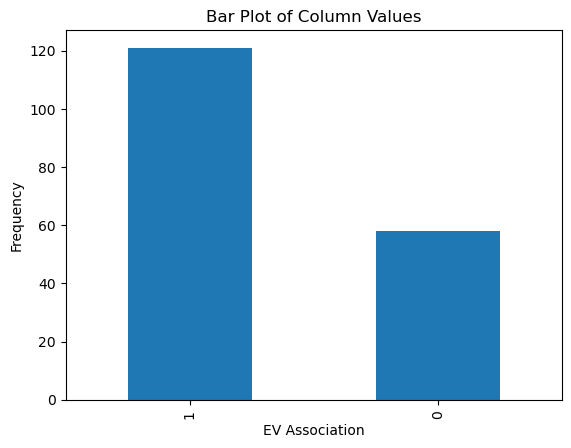

In [39]:
#checking the left over EV association.
result['EV'].value_counts().plot(kind='bar')

# Add labels and title
plt.xlabel('EV Association')
plt.ylabel('Frequency')
plt.title('Bar Plot of Column Values')

# Show the plot
plt.show()

In [40]:
final_df = final_df.drop('Classification', axis = 1)
final_df = final_df.drop('Unnamed: 0', axis = 1)

In [41]:
final_df.columns

Index(['Uniprot', 'Filtered_Classification', 'Region_Classification',
       'Sequence', 'Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G',
       'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
       'Isoelectric point', 'Instability index', 'Disorder', 'Helix', 'Coil',
       'Sheet', 'Signal peptide', 'NetNGlyc',
       'N-linked Glycosylation (GlycoMine)',
       'O-linked Glycosylation (GlycoMine)',
       'C-linked Glycosylation (GlycoMine)', 'Cytoplasm', 'Extracellular',
       'Lysosome/Vacuole', 'Nucleus', 'Cell membrane', 'Endoplasmic reticulum',
       'Mitochondrion', 'Golgi apparatus', 'Peroxisome', 'Plastid',
       'TM region', 'TM region (binary)', 'GPI-anchor', 'EGF1', 'EGF2',
       'Cadherin-1', 'G-protein receptor F1', 'Zinc Finger C2H2', 'Homeobox',
       'RNA binding', 'DNA binding', 'Ectodomain shedding protein', 'EV',
       'CSF'],
      dtype='object')

In [42]:
#austin's random forest with three classes. on kathi's data.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


data = only_kathi_features_df.copy()

# create X and Y 
X = data.drop(['Uniprot','Filtered_Classification','Region_Classification','Sequence', 'CSF','Classification','Unnamed: 0'], axis=1)
y = data['Filtered_Classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Get feature importances
rf_feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
rf_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})

# Sort the DataFrame by importance in descending order
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

print(rf_importance_df.count())


Accuracy: 0.77
Classification Report:
                    precision    recall  f1-score   support

    Fully_Secreted       0.70      0.38      0.49        55
      Not_Secreted       0.79      0.98      0.87       588
Partially_Secreted       0.48      0.12      0.20       160

          accuracy                           0.77       803
         macro avg       0.66      0.50      0.52       803
      weighted avg       0.72      0.77      0.71       803

Confusion Matrix:
[[ 21  23  11]
 [  0 577  11]
 [  9 131  20]]
Feature       56
Importance    56
dtype: int64


In [139]:
#austin's random forest with three classes.
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


data = final_df.copy()

# create X and Y 
X = data.drop(['Uniprot','Filtered_Classification','Region_Classification','Sequence'], axis=1)
y = data['Filtered_Classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Get feature importances
rf_feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
rf_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})

# Sort the DataFrame by importance in descending order
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

print(rf_importance_df.count())


Accuracy: 0.83
Classification Report:
                    precision    recall  f1-score   support

    Fully_Secreted       0.73      0.52      0.61       163
      Not_Secreted       0.86      0.95      0.90       577
Partially_Secreted       0.59      0.35      0.44        37

          accuracy                           0.83       777
         macro avg       0.73      0.61      0.65       777
      weighted avg       0.82      0.83      0.82       777

Confusion Matrix:
[[ 85  74   4]
 [ 23 549   5]
 [  8  16  13]]
Feature       57
Importance    57
dtype: int64


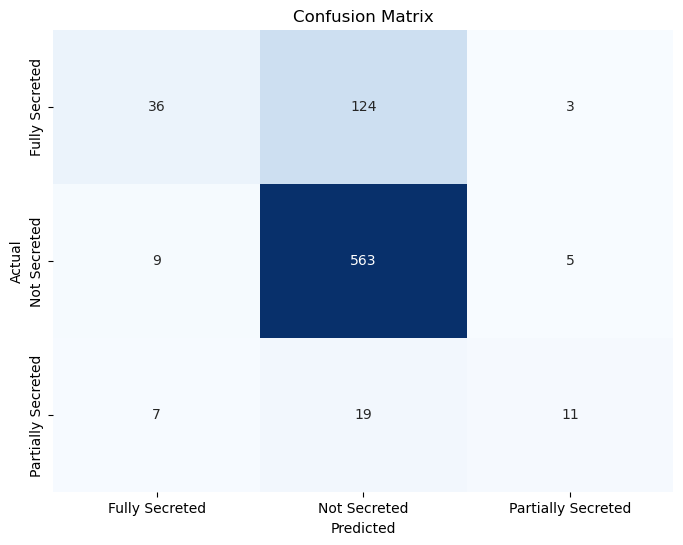

<Figure size 640x480 with 0 Axes>

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your actual and predicted labels
cm = confusion_matrix(y_test, y_pred)

# Get class labels (assuming you have a class_names list)
class_names = ['Fully Secreted', 'Not Secreted', 'Partially Secreted']  # Replace with your actual class names

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.savefig('austin_new_figs/Confusion_Matrix_Three_Class_RF_More_Features.png',dpi=300, bbox_inches = "tight")
plt.show()

In [136]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Get feature importances
rf_feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to display feature importances
rf_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})

# Sort the DataFrame by importance in descending order
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

print(rf_importance_df.count())

Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       788
           1       0.77      0.46      0.58       247

    accuracy                           0.84      1035
   macro avg       0.81      0.71      0.74      1035
weighted avg       0.83      0.84      0.82      1035

Confusion Matrix:
[[755  33]
 [134 113]]
Feature       56
Importance    56
dtype: int64


In [106]:
#The above code produces a decent Accuracy and Precision. If the eventual goal is biomarker prediction, then this
# is probably a good idea.

In [ ]:
# trying another classification method.


In [69]:
'''
Test the robustness of the machine learning model by perfoming repeated stratified K fold with the random forest model
'''
def RobustnessTest(X_train,y_train):
    skf = RepeatedStratifiedKFold(n_splits=5,n_repeats=3)
    acc = []
    bacc = []
    auc = []
    f1 = []

    for train_index, test_index in skf.split(X_train, y_train):
        x_train_fold, x_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        rf_model = BalancedRandomForestClassifier()  
        # under sample training data
        rf_model.fit(x_train_fold, y_train_fold)
        y_pred = rf_model.predict(x_test_fold)
        acc.append(accuracy_score(y_test_fold, y_pred))
        bacc.append(balanced_accuracy_score(y_test_fold, y_pred))
        auc.append(roc_auc_score(y_test_fold, y_pred))
        f1.append(f1_score(y_test_fold, y_pred))
    return acc,bacc,auc,f1

In [101]:
data = final_df.copy()

proteinmodel_results = {}

category_mapping = {
    'Not_Secreted': 0,
    'Partially_Secreted': 1,
    'Fully_Secreted': 1 
}

# Binary Classifications made
data['Secreted'] = final_df['Filtered_Classification'].map(category_mapping)

#FIRST BINARY MODEL = SECRETED VS NOT
X = data.drop(['Uniprot','Filtered_Classification','Region_Classification','Sequence', 'CSF', 'Secreted'], axis=1)
y1 = data['Filtered_Classification']


X_train, X_test, y_train, y_test = train_test_split(X, y1,stratify=y,test_size=0.2,random_state=42)    
    # Create models
rf_model = RandomForestClassifier(random_state=42)    
    # Test for robustness on training split
#acc,bacc,auc,f1 = RobustnessTest(X_train,y_train)

    # Tests model on test split after training
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.80
Classification Report:
                    precision    recall  f1-score   support

    Fully_Secreted       0.70      0.28      0.40       201
      Not_Secreted       0.82      0.97      0.89       788
Partially_Secreted       0.47      0.15      0.23        46

          accuracy                           0.80      1035
         macro avg       0.66      0.47      0.51      1035
      weighted avg       0.78      0.80      0.77      1035

Confusion Matrix:
[[ 57 139   5]
 [ 18 767   3]
 [  7  32   7]]


In [47]:
# Finding the average value 
average_value = rf_importance_df['Importance'].mean()

print("Average value of the column:", average_value)

Average value of the column: 0.017857142857142856


In [48]:
# Boolean indexing to isolate values above the average
above_average_values = rf_importance_df[rf_importance_df['Importance'] > average_value]

print("Values above the average:")
print(above_average_values['Feature'].tolist())

Values above the average:
['Signal peptide', 'L', 'H', 'Helix', 'EV', 'Sheet', 'Isoelectric point', 'K', 'C', 'R', 'G', 'Instability index', 'D', 'E', 'Molecular weight', 'N', 'Length', 'S', 'F', 'I', 'Disorder', 'W', 'A', 'T', 'Coil', 'Y', 'V', 'P', 'Q', 'M', 'Extracellular']


In [49]:
# Boolean indexing to isolate values UNDER the average
below_average_values = rf_importance_df[rf_importance_df['Importance'] < average_value]

print("Values above the average:")
print(below_average_values['Feature'].tolist())

Values above the average:
['Ectodomain shedding protein', 'Cell membrane', 'TM region', 'TM region (binary)', 'Mitochondrion', 'Cytoplasm', 'N-linked Glycosylation (GlycoMine)', 'Nucleus', 'O-linked Glycosylation (GlycoMine)', 'RNA binding', 'DNA binding', 'GPI-anchor', 'Endoplasmic reticulum', 'NetNGlyc', 'Golgi apparatus', 'Peroxisome', 'Lysosome/Vacuole', 'Plastid', 'EGF1', 'C-linked Glycosylation (GlycoMine)', 'EGF2', 'Zinc Finger C2H2', 'Cadherin-1', 'G-protein receptor F1', 'Homeobox']


In [ ]:
#